# Tweets einlesen
Die Twitterdaten stammen von [Tweet Archivist](https://www.tweetarchivist.com/). Diese Quelle habe ich in diversen Wissenschaftlichen Papers gefunden und sollte zuverlässig sein. Im Moment habe ich dort mehrere Queries hinterlegt, welche ab mitte November alle Tweets zum entsprechenden Query "abgrasen". Dabei habe ich verschiedene Kryptowährungen auf dem Radar.

Für dieses Beispiel habe ich jedoch noch die Kryptowährung "Bitcoin" verwendet.

TODO's:
* Data cleansing: Bot detection, Sprache richtig behandeln, evtl. NLTK preprocessing pipeline (stopwords, etc.), emojis?

In [2]:
import pandas as pd
import numpy as np
df = pd.read_excel("./data/bitcoin_tweets.xlsx")
df['Universal Time Stamp'] = pd.to_datetime(df['Universal Time Stamp'])
df['Date'] = df['Universal Time Stamp'].apply( lambda df : pd.datetime(year=df.year, month=df.month, day=df.day))
df.head()

ID        User Name Universal Time Stamp  \
0  1057493160732049408         BenHakes  2018-10-31 04:43:11   
1  1057493026459865088      luckymurari  2018-10-31 04:42:39   
2  1057492913259769856      DomainArt4u  2018-10-31 04:42:12   
3  1057492911317757953  BitcoinMagazine  2018-10-31 04:42:11   
4  1057492852039696385     cryptosuntsu  2018-10-31 04:41:57   

      Local Time Stamp                                               Text  \
0  2018-10-31T04:43:11  Yellen concern trolling Bitcoin reminded me of...   
1  2018-10-31T04:42:39  RT @needacoin: Ten years ago Satoshi Nakamoto ...   
2  2018-10-31T04:42:12  Great#ico #airdrop #eth #btc #PRX #blockchain ...   
3  2018-10-31T04:42:11  Happy Birthday, Bitcoin! A Letter From Ross Ul...   
4  2018-10-31T04:41:57  RT @CryptoBoomNews: Happy 10th Birthday #Bitco...   

  Language                                      Profile Image  \
0       en  http://pbs.twimg.com/profile_images/1054823665...   
1       en  http://pbs.twimg.com/profile_images/1038036543...   
2       en  http://pbs.twimg.com/profile_images/8481878445...   
3       en  http://pbs.twimg.com/profile_images/9276975225...   
4       en  http://pbs.twimg.com/profile_images/9540367703...   

                                              Source              Location  \
0  <a href="http://twitter.com/download/iphone" r...                  Here   
1  <a href="http://twitter.com/download/android" ...                 India   
2  <a href="http://twitter.com" rel="nofollow">Tw...            Bangladesh   
3  <a href="https://about.twitter.com/products/tw...         Nashville, TN   
4  <a href="http://twitter.com" rel="nofollow">Tw...  Sedona, Arizona, USA   

   Time Zone  Geo                                           Hashtags  \
0        NaN  NaN                                                NaN   
1        NaN  NaN                                            bitcoin   
2        NaN  NaN  ico airdrop eth btc PRX blockchain giveaway to...   
3        NaN  NaN                       FreeRoss BitcoinAt10 bitcoin   
4        NaN  NaN                                            Bitcoin   

                                                Urls   User Mentions Media  \
0  https://twitter.com/i/web/status/1057493160732...         nntaleb   NaN   
1                                                NaN       needacoin   NaN   
2  https://twitter.com/i/web/status/1057492913259...             NaN   NaN   
3  https://bitcoinmagazine.com/articles/happy-bir...       Free_Ross   NaN   
4                                                NaN  CryptoBoomNews   NaN   

   Follower Count              Name       Date  
0             472         Ben Hakes 2018-10-31  
1           11030      Lucky Murari 2018-10-31  
2            1250    Md Abdul Based 2018-10-31  
3          537797  Bitcoin Magazine 2018-10-31  
4             247  CryptoSunTsunami 2018-10-31

# Simple Sentiment Analyse mit AFINN
Folgend werden die Tweets mit einem simplen Sentiment Analysis Modell klassifiziert. Hier habe ich [AFINN](https://github.com/fnielsen/afinn) verwendet, weil dieses Modell ziemlich einfach und performant ist. Die Verwendung weiterer Modelle wird Beispielsweise [hier](https://www.kdnuggets.com/2018/08/emotion-sentiment-analysis-practitioners-guide-nlp-5.html) erklärt. Auch in der Literatur habe ich schon Modelle gefunden. Grundsätzlich will ich ein Modell einsetzen, welches bereits Wissenschaftlich in diesem zusammenhang eingestzt wurde. Evtl. könnte ich hier auch noch einen Vergleich anstreben.

In [129]:
from afinn import Afinn
afinn = Afinn()

for index, row in df.iterrows():
    df.loc[index, 'sentiment score'] = afinn.score(row['Text']) 

## Positive, negative, etc. Tweets zählen
Die Korrelationsanalyse sollte schlussendlich auf der Anzahl positiven/negativen Tweets basieren. Hierfür wird im folgenden Code-Abschnitt die Grundlage gelegt.

Man könnte aber auch noch weiter gehen und Beispielsweise das Verhältniss von positiven und negativen genauer analysieren. Oder man bestimmt die relative Veränderung zum Vortag.

In [191]:
tweets_per_day = pd.DataFrame({}, columns = ['Date', 'total_tweets', 'positive_tweets', 'neutral_tweets', 'negative_tweets', 'sentiment_sum'])
for (date, group) in df.groupby('Date'):
    # print("{0} - {1}".format(date, type(group)))
    counts = len(group)
    pos = len(group[group['sentiment score'] > 0])
    neut = len(group[group['sentiment score'] == 0])
    neg = len(group[group['sentiment score'] < 0])
    sentiment_sum = group['sentiment score'].sum()
    # print("counts: {0}".format(counts))
    # print("positive: {0}".format(pos))    
    # print("neutral: {0}".format(neut))    
    # print("negative: {0}".format(neg))
    row = pd.Series({'Date':date,'total_tweets':counts,'positive_tweets':pos,'neutral_tweets':neut,'negative_tweets':neg,'sentiment_sum':sentiment_sum})
    tweets_per_day = tweets_per_day.append(row,ignore_index=True)
tweets_per_day['Date'] = pd.to_datetime(tweets_per_day['Date'])
tweets_per_day['Date'] = tweets_per_day['Date'].apply( lambda df : datetime.datetime(year=df.year, month=df.month, day=df.day))
tweets_per_day.head()

Date total_tweets positive_tweets neutral_tweets negative_tweets  \
0 2018-10-31         2489            1975            389             125   
1 2018-11-01         2259            1808            345             106   
2 2018-11-02         2090            1783            174             133   
3 2018-11-03         1645            1249            145             251   
4 2018-11-04         1447            1074            139             234   

   sentiment_sum  
0         7820.0  
1         7966.0  
2         7719.0  
3         5301.0  
4         3911.0

# Kryptowährungsdaten
Hier werden nun die Kryptowährungsdaten mittel [API](https://min-api.cryptocompare.com) angezogen.

In [3]:
import requests
import datetime
import pandas as pd
import matplotlib.pyplot as plt
def daily_price_historical(symbol, comparison_symbol, all_data=True, limit=1, aggregate=1, exchange=''):
    url = 'https://min-api.cryptocompare.com/data/histoday?fsym={}&tsym={}&limit={}&aggregate={}'\
            .format(symbol.upper(), comparison_symbol.upper(), limit, aggregate)
    if exchange:
        url += '&e={}'.format(exchange)
    if all_data:
        url += '&allData=true'
    page = requests.get(url)
    data = page.json()['Data']
    df = pd.DataFrame(data)
    df['timestamp'] = [datetime.datetime.fromtimestamp(d) for d in df.time]
    return df

In [4]:
cd = daily_price_historical('BTC', 'USD', limit=50)
cd['Universal Time Stamp'] = pd.to_datetime(cd['timestamp'])
cd['Date'] = cd['Universal Time Stamp'].apply( lambda df : datetime.datetime(year=df.year, month=df.month, day=df.day))
print('length = %s' % len(cd))
cd.head()

length = 3140


close     high      low     open        time  volumefrom  volumeto  \
0  0.04951  0.04951  0.04951  0.04951  1279324800       20.00    0.9902   
1  0.08584  0.08585  0.05941  0.04951  1279411200       75.01    5.0900   
2  0.08080  0.09307  0.07723  0.08584  1279497600      574.00   49.6600   
3  0.07474  0.08181  0.07426  0.08080  1279584000      262.00   20.5900   
4  0.07921  0.07921  0.06634  0.07474  1279670400      575.00   42.2600   

            timestamp Universal Time Stamp       Date  
0 2010-07-17 02:00:00  2010-07-17 02:00:00 2010-07-17  
1 2010-07-18 02:00:00  2010-07-18 02:00:00 2010-07-18  
2 2010-07-19 02:00:00  2010-07-19 02:00:00 2010-07-19  
3 2010-07-20 02:00:00  2010-07-20 02:00:00 2010-07-20  
4 2010-07-21 02:00:00  2010-07-21 02:00:00 2010-07-21

In [10]:
cd2 = daily_price_historical('LTC', 'USD', limit=50)
cd2['Universal Time Stamp'] = pd.to_datetime(cd2['timestamp'])
cd2['Date'] = cd['Universal Time Stamp'].apply( lambda df : datetime.datetime(year=df.year, month=df.month, day=df.day))
print('length = %s' % len(cd2))
cd2.head()

length = 1945


close  high  low  open        time  volumefrom  volumeto  \
0    3.0   3.0  3.0   3.0  1382572800        2.71      8.12   
1    3.0   3.0  3.0   3.0  1382659200        0.00      0.00   
2    3.0   3.0  3.0   3.0  1382745600        0.00      0.00   
3    3.0   3.0  3.0   3.0  1382832000        0.00      0.00   
4    3.0   3.0  3.0   3.0  1382918400        0.00      0.00   

            timestamp Universal Time Stamp       Date  
0 2013-10-24 02:00:00  2013-10-24 02:00:00 2010-07-17  
1 2013-10-25 02:00:00  2013-10-25 02:00:00 2010-07-18  
2 2013-10-26 02:00:00  2013-10-26 02:00:00 2010-07-19  
3 2013-10-27 02:00:00  2013-10-27 02:00:00 2010-07-20  
4 2013-10-28 01:00:00  2013-10-28 01:00:00 2010-07-21

## Empfangene Kursdaten plotten

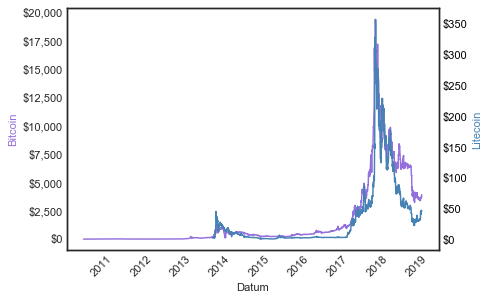

In [24]:
import matplotlib as matplt
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

linewidth = 1.3

plt.style.use('seaborn-white')
fig = plt.figure(num=None, figsize=(6, 4), dpi=80, facecolor='w', edgecolor='k')
ax1 = fig.add_subplot(111)
ax1.yaxis.set_major_formatter(ticker.StrMethodFormatter('${x:,.0f}')) 
ax1.set_ylabel('Bitcoin', color='mediumpurple')
ax1.set_xlabel('Datum')
plt.plot(cd.timestamp, cd.close, color='mediumpurple', linewidth=linewidth)
plt.xticks(rotation=45)

ax2 = ax1.twinx()
ax2.plot(cd2.timestamp, cd2.close, color='steelblue', label='Tweets Total', linewidth=linewidth)
ax2.yaxis.set_major_formatter(ticker.StrMethodFormatter('${x:,.0f}')) 
ax2.set_ylabel('Litecoin', color='steelblue')
ax2.grid(False)
for tl in ax2.get_yticklabels():
    tl.set_color('black')

plt.show()

# Twitter- und Kryptowährungs- Daten zusammenführen

In [225]:
result = pd.merge(cd, tweets_per_day, on='Date')
result.head()

close     high      low     open        time  volumefrom      volumeto  \
0  6342.61  6391.25  6241.49  6309.11  1540944000    38823.41  2.453572e+08   
1  6381.30  6402.59  6322.60  6342.81  1541030400    31397.71  1.998612e+08   
2  6394.66  6420.93  6371.57  6381.30  1541116800    27987.60  1.793856e+08   
3  6376.32  6398.09  6336.96  6394.65  1541203200    28808.38  1.835653e+08   
4  6467.05  6498.16  6351.92  6376.55  1541289600    27317.02  1.758052e+08   

            timestamp Universal Time Stamp       Date total_tweets  \
0 2018-10-31 01:00:00  2018-10-31 01:00:00 2018-10-31         2489   
1 2018-11-01 01:00:00  2018-11-01 01:00:00 2018-11-01         2259   
2 2018-11-02 01:00:00  2018-11-02 01:00:00 2018-11-02         2090   
3 2018-11-03 01:00:00  2018-11-03 01:00:00 2018-11-03         1645   
4 2018-11-04 01:00:00  2018-11-04 01:00:00 2018-11-04         1447   

  positive_tweets neutral_tweets negative_tweets  sentiment_sum  
0            1975            389             125         7820.0  
1            1808            345             106         7966.0  
2            1783            174             133         7719.0  
3            1249            145             251         5301.0  
4            1074            139             234         3911.0

# Daten anreichern
Hier werden die Daten mit relativen veränderungen in Prozent angereichert.

In [233]:
result['close_relative_change'] = result['close'].pct_change().apply(lambda x: x * 100).fillna(0)
result['total_tweets_relative_change'] = result['total_tweets'].pct_change().apply(lambda x: x * 100).fillna(0)
result['positive_tweets_relative_change'] = result['positive_tweets'].pct_change().apply(lambda x: x * 100).fillna(0)
result['negative_tweets_relative_change'] = result['negative_tweets'].pct_change().apply(lambda x: x * 100).fillna(0)
result['neutral_tweets_relative_change'] = result['neutral_tweets'].pct_change().apply(lambda x: x * 100).fillna(0)
result['sentiment_sum_relative_change'] = result['sentiment_sum'].pct_change().apply(lambda x: x * 100).fillna(0)
result.head()

close     high      low     open        time  volumefrom      volumeto  \
0  6342.61  6391.25  6241.49  6309.11  1540944000    38823.41  2.453572e+08   
1  6381.30  6402.59  6322.60  6342.81  1541030400    31397.71  1.998612e+08   
2  6394.66  6420.93  6371.57  6381.30  1541116800    27987.60  1.793856e+08   
3  6376.32  6398.09  6336.96  6394.65  1541203200    28808.38  1.835653e+08   
4  6467.05  6498.16  6351.92  6376.55  1541289600    27317.02  1.758052e+08   

            timestamp Universal Time Stamp       Date  \
0 2018-10-31 01:00:00  2018-10-31 01:00:00 2018-10-31   
1 2018-11-01 01:00:00  2018-11-01 01:00:00 2018-11-01   
2 2018-11-02 01:00:00  2018-11-02 01:00:00 2018-11-02   
3 2018-11-03 01:00:00  2018-11-03 01:00:00 2018-11-03   
4 2018-11-04 01:00:00  2018-11-04 01:00:00 2018-11-04   

               ...               positive_tweets neutral_tweets  \
0              ...                          1975            389   
1              ...                          1808            345   
2              ...                          1783            174   
3              ...                          1249            145   
4              ...                          1074            139   

  negative_tweets sentiment_sum  close_relative_change  \
0             125        7820.0               0.000000   
1             106        7966.0               0.610001   
2             133        7719.0               0.209362   
3             251        5301.0              -0.286802   
4             234        3911.0               1.422921   

   total_tweets_relative_change  positive_tweets_relative_change  \
0                      0.000000                         0.000000   
1                     -9.240659                        -8.455696   
2                     -7.481186                        -1.382743   
3                    -21.291866                       -29.949523   
4                    -12.036474                       -14.011209   

   negative_tweets_relative_change  neutral_tweets_relative_change  \
0                         0.000000                        0.000000   
1                       -15.200000                      -11.311054   
2                        25.471698                      -49.565217   
3                        88.721805                      -16.666667   
4                        -6.772908                       -4.137931   

   sentiment_sum_relative_change  
0                       0.000000  
1                       1.867008  
2                      -3.100678  
3                     -31.325301  
4                     -26.221468  

[5 rows x 21 columns]

In [243]:
result['total_tweets'] = pd.to_numeric(result['total_tweets'])
result['positive_tweets'] = pd.to_numeric(result['positive_tweets'])
result['neutral_tweets'] = pd.to_numeric(result['neutral_tweets'])
result['negative_tweets'] = pd.to_numeric(result['negative_tweets'])

In [245]:
result.corr(method='pearson').style.format("{:.2}").background_gradient(cmap=plt.get_cmap('coolwarm'), axis=1)

# Grafische darstellung zwischen Kurs- und Twitter Daten

In [223]:
fig = plt.figure(num=None, figsize=(16, 12), dpi=80, facecolor='w', edgecolor='k')
ax1 = fig.add_subplot(111)
plt.plot(result['Date'], result.close, 'black')
plt.xticks(rotation=45)
ax1.set_ylabel('price')

ax2 = ax1.twinx()
ax2.plot(result['Date'], result.total_tweets, 'silver')
ax2.set_ylabel('Tweets', color='silver')
for tl in ax2.get_yticklabels():
    tl.set_color('silver')
    
ax3 = ax2.twiny()
ax3.plot(result['Date'], result.positive_tweets, 'green')
ax3.set_ylabel('Positive Tweets', color='green')
ax3.tick_params(top='off', bottom='off', left='off', right='off', labeltop='off', labelbottom='off', labelleft='off', labelright='off')

ax3 = ax2.twiny()
ax3.plot(result['Date'], result.negative_tweets, 'red')
ax3.set_ylabel('Negative Tweets', color='red')
ax3.tick_params(top='off', bottom='off', left='off', right='off', labeltop='off', labelbottom='off', labelleft='off', labelright='off')

fig.legend(loc=1)
plt.show()